In [1]:
import sys
sys.path.append('models/')
sys.path.append('eval/')
sys.path.append('process_data/')

import libpysal
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle as pkl
import scipy

# custom GCNN classes
from class_dataset import CTA_Data
from class_gcn_lstm import GCN_LSTM
from class_mve_loss import LN_MVELoss
from class_mve_loss import T_MVELoss

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

import util_gcnn
import util_eval
import util_plot
from setup import *

%matplotlib inline
%load_ext autoreload
%autoreload 2
plt.rcParams.update({'font.size': 16})

# Set up and Hyperparameters

In [2]:
out_folder = "2102_rc_new1"

period = "after"
dist = "tnorm"
dropout_rate_list=[0.25, 0.5]
n_hid_units_list=[50,100,150]
weight_decay_list = [0.001, 0.005, 0.01, 0.05]
ngc_list = [1,2,3]
nlstm_list = [1,2,3]

max_lookback = 6
lookback = 6 
time_size = 4
predict_hzn = 1
n_time = 96 // time_size - 7

# type of adjcency matrix
# con-connectivity; net-network distance; euc-euclidean distance; func-functional similarity
adj_type = ["func","euc","con","net"]

train_extent = "downtown"
difference = True

# 95% pct
z=1.96

In [3]:
data, adj, spatial, downtown_filter = \
    util_gcnn.combine_datasources(project_dir, period, predict_hzn, time_size, difference, max_lookback, lookback)

print("Data sources and shapes:")
for key,items in data.items():
    print(key, "\t", items[0].shape)

Data sources and shapes:
x 	 (3146, 6, 134, 3)
y 	 (3146, 1, 134)
ref 	 (3146, 1, 134)
los 	 (3146, 1, 134)
weather 	 (3146, 2)
qod 	 (3146,)
ts 	 (3146,)
stations 	 ()


In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
train_extent = 'downtown'
trainloader, trainloader_test, testloader, adj_torch, spatial_torch, y_train_eval, y_test_eval = \
                            util_gcnn.prepare_for_torch(device, train_extent, 
                            data,
                            adj, spatial, downtown_filter, adj_type)

In [5]:
(num_train, _, _, n_modes) = data['x'][0].shape
(num_test, _, _, _) = data['x'][1].shape
n_stations = adj_torch.shape[0]

In [6]:
y_train_eval = np.squeeze(y_train_eval)
y_test_eval = np.squeeze(y_test_eval)

# Training

In [8]:
max_epochs = 501
start_hp = 0
end_hp = 1
same_hp = False
spatial_torch = None

# hp_index = 71
# saved_model = torch.load(project_dir+"models/center_MVE_"+str(hp_index)+".pt")
# hp = saved_model['hyperparameters']

for ii in range(start_hp, end_hp):

    # draw hyperparameters
    dropout = np.random.choice(dropout_rate_list)
    n_hid_units = np.random.choice(n_hid_units_list)
    weight_decay = np.random.choice(weight_decay_list)
    nlstm = np.random.choice(nlstm_list)
    ngc = np.random.choice(ngc_list)
    
    print('Model ', ii)
    print('Lookback: ', lookback)
    
    net = GCN_LSTM(meanonly=False, nadj = len(adj_type), nmode=n_modes, nstation=n_stations, ntime=n_time, ndemo=0,
              nhid_g=n_hid_units, ngc=ngc, nhid_l=n_hid_units, nlstm=nlstm, 
              nhid_fc=n_hid_units, dropout=dropout)
    net.to(device)
    if dist == 'lognorm':
        criterion = LN_MVELoss()
    else:  
        criterion = T_MVELoss()
    optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=weight_decay)
    
    success=True 
    best = 0
    best_epoch = 0
    ref1 = 0
    ref2 = 0
    
    for epoch in range(max_epochs):
        
        running_loss = 0.0

        for i, batch_data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels, history, quarter of the day]
            batch_x, batch_y, batch_history, batch_weather, batch_los, batch_qod = batch_data
        

            batch_size=len(batch_x)
            
            batch_x = batch_x.float()
            batch_y = batch_y.float()
            batch_history = batch_history.float()
            batch_qod = batch_qod.view(-1,1)
            batch_qod_onehot = torch.FloatTensor(batch_size, n_time)
            batch_qod_onehot.zero_()
            batch_qod_onehot.scatter_(1, batch_qod-6, 1)
            batch_x, batch_y, batch_history, batch_weather, batch_los, batch_qod_onehot = \
                batch_x.to(device), batch_y.to(device), batch_history.to(device), \
                batch_weather.to(device), batch_los.to(device), batch_qod_onehot.to(device)
            
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward 
            outputs = net(batch_x, None, adj_torch, batch_history, spatial_torch, 
                          batch_weather, batch_los, batch_qod_onehot, 1)
            output_loc = outputs[:batch_size,:]
            output_scale = outputs[batch_size:,:]
            
            # loss
            loss = criterion(output_loc, output_scale, batch_y)
            
            # backward
            loss.backward()

            # optimize
            optimizer.step()

            running_loss += loss.item()

            if torch.sum(torch.isnan(output_loc)) > 0:
                    success=False
                    break
                
        if not success:
            break
        
        if epoch % 50 == 0:
            print('[%d] training loss: %.3f' %
              (epoch + 1, running_loss/num_train), end = '\t')
            
            net.eval()
            test_out_loc, test_out_std, test_loss = util_gcnn.testset_output_gcn(testloader, False, net, criterion, adj_torch, 
                                                                      spatial_torch, device, n_time)

            if dist == "lognorm":
                test_out_loc = np.exp(test_out_loc - np.power(test_out_std,2))
                
            mae = np.mean(np.abs(test_out_loc - y_test_eval))
            print("TEST LOSS %.2f, MAE %.2f, STD %.2f" % (test_loss, mae, np.mean(test_out_std)))
            

        if epoch % 10 == 0:
            if epoch > 40:
                if (np.abs(running_loss - ref1)/ref1<0.005) & (np.abs(running_loss - ref2)/ref2<0.005):
                    print("Early Stopping at Epoch", epoch)
                    break
                if (ref1 < running_loss) & (ref1 < ref2):
                    print("Diverging. Stop.")
                    break
                if running_loss < best:
                    best = running_loss
                    best_epoch = epoch
            else:
                best = running_loss
                best_epoch = epoch

            ref2 = ref1
            ref1 = running_loss

        net.train()

    if not success:
        print('Training Failed ', str(ii))
        continue
    
    print('Finished Training ', str(ii))
    
    net.eval()
    
    test_out_loc, test_out_std, test_loss = util_gcnn.testset_output_gcn(testloader, False, net, criterion, 
                                                                          adj_torch, spatial_torch, device, n_time)
    if dist == "lognorm":
        test_out_loc = np.exp(test_out_loc - np.power(test_out_std,2))
        test_out_lb = np.exp(test_out_loc - z*test_out_std)
        test_out_ub = np.exp(test_out_loc + z*test_out_std)
    elif dist == 'tnorm':
        test_out_lb = test_out_loc - z*test_out_std
        test_out_ub = test_out_loc + z*test_out_std
    mae, mse, _, _, _ = util_eval.eval_mean(test_out_loc, y_test_eval, 'Test')
    mpiw, picp = util_eval.eval_pi(test_out_lb, test_out_ub, y_test_eval)
    u, ub, uv, uc = util_eval.eval_theils(test_out_loc, y_test_eval)
    #print(u, ub, uv, uc)
    
    train_out_loc, train_out_std, train_loss = util_gcnn.testset_output_gcn(trainloader_test, False, net, criterion, 
                                                                             adj_torch, spatial_torch, device, n_time)

    if dist == "lognorm":
        train_out_loc = np.exp(train_out_loc - np.power(train_out_std,2))
        train_out_lb = np.exp(train_out_loc - z*train_out_std)
        train_out_ub = np.exp(train_out_loc + z*train_out_std)
    elif dist == 'tnorm':
        train_out_lb = train_out_loc - z*train_out_std
        train_out_ub = train_out_loc + z*train_out_std
        
    tr_mae, tr_mse, _, _, pct_nonzeros = util_eval.eval_mean(train_out_loc, y_train_eval, 'Train')
    tr_mpiw, tr_picp = util_eval.eval_pi(train_out_lb, train_out_ub, y_train_eval)

    with open(project_dir+"results/rail_catchment_mve_results.csv","a") as f:
        f.write("%s,%s,%s,%s,%s,%d,%d,%d,%d,%.2f,%d,%d,%d,%.2E,%.2f,%.2f,%.2f,%.6f,%.6f,%.2f,%.2f,%.2f,%.6f,%.6f\n" % 
                ("GCN", period, train_extent, train_extent, '_'.join(adj_type), ii, 
                predict_hzn, time_size, lookback, 
                dropout, n_hid_units, nlstm, ngc, weight_decay, 
                train_loss/num_train, tr_mae, tr_mse, tr_mpiw, tr_picp,
                test_loss/num_test, mae, mse, mpiw, picp))
        
    if train_extent == 'all':
        mae, mse, _, _, _ = util_eval.eval_mean(test_out_loc[:,downtown_filter], 
                                                y_test_eval[:,downtown_filter], 'Test')
        mpiw, picp = util_eval.eval_pi(test_out_loc[:,downtown_filter] - z*test_out_std[:,downtown_filter], 
                                       test_out_loc[:,downtown_filter] + z*test_out_std[:,downtown_filter], 
                                       y_test_eval[:,downtown_filter])
        tr_mae, tr_mse, _, _, pct_nonzeros = util_eval.eval_loc(train_out_loc[:,downtown_filter], 
                                                                 y_train_eval[:,downtown_filter], 'Train')
        tr_mpiw, tr_picp = util_eval.eval_pi(train_out_loc[:,downtown_filter] - z*train_out_std[:,downtown_filter], 
                                             train_out_loc[:,downtown_filter] + z*train_out_std[:,downtown_filter], 
                                             y_train_eval[:,downtown_filter])

        with open(project_dir+"results/rail_catchment_mve_results.csv","a") as f:
            f.write("%s,%s,%s,%s,%s,%d,%d,%d,%d,%.2f,%d,%d,%d,%.2E,%.2f,%.2f,%.2f,%.6f,%.6f,%.2f,%.2f,%.2f,%.6f,%.6f\n" % 
                    ("GCN", period, train_extent, 'downtown', '_'.join(adj_type), ii, 
                    predict_hzn, time_size, lookback, 
                    dropout, n_hid_units, nlstm, ngc, weight_decay, 
                    train_loss/num_train, tr_mae, tr_mse, tr_mpiw, tr_picp,
                    test_loss/num_test, mae, mse, mpiw, picp))
        
    '''
    # save model        
    torch.save({'epoch': epoch,
            'model_state_dict': net.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': running_loss,
            'hyperparameters': (lookback, dropout, n_hid_units, weight_decay)
            }, project_dir+"models/"+out_folder+"/"+period+"_"+adj_type+"_"+str(lookback)+"_"+str(ii)+".pt")
    '''

Model  0
Lookback:  6
[1] training loss: 911.065	TEST LOSS 28372.54, MAE 14.98, STD 68.07
[51] training loss: 66.225	TEST LOSS 24849.47, MAE 13.65, STD 16.83
[101] training loss: 65.237	TEST LOSS 24807.49, MAE 13.81, STD 16.24
Early Stopping at Epoch 100
Finished Training  0


In [11]:
for p in net.named_parameters():
    print(p[0], p[1].shape)

history_weights_mean torch.Size([17, 18])
weather_weights_mean torch.Size([17, 36])
los_weights_mean torch.Size([17, 18])
weather_weights_var torch.Size([17, 36])
history_weights_var torch.Size([17, 18])
batchnorm.weight torch.Size([18])
batchnorm.bias torch.Size([18])
gc.0.0.weight torch.Size([3, 50])
gc.0.0.bias torch.Size([50])
gc.0.1.weight torch.Size([50, 50])
gc.0.1.bias torch.Size([50])
gc.1.0.weight torch.Size([3, 50])
gc.1.0.bias torch.Size([50])
gc.1.1.weight torch.Size([50, 50])
gc.1.1.bias torch.Size([50])
fc1.weight torch.Size([50, 900])
fc1.bias torch.Size([50])
fc2.weight torch.Size([50, 50])
fc2.bias torch.Size([50])
lstm.weight_ih_l0 torch.Size([200, 50])
lstm.weight_hh_l0 torch.Size([200, 50])
lstm.bias_ih_l0 torch.Size([200])
lstm.bias_hh_l0 torch.Size([200])
lstm.weight_ih_l1 torch.Size([200, 50])
lstm.weight_hh_l1 torch.Size([200, 50])
lstm.bias_ih_l1 torch.Size([200])
lstm.bias_hh_l1 torch.Size([200])
lstm.weight_ih_l2 torch.Size([200, 50])
lstm.weight_hh_l2 torch

## Fit

(Test) Mean Absolute Error: 68.915
(Test) Mean Squared Error: 25408.108
Percent Nonzeros: 99%
Nonzero Entries:
(Test) Mean Absolute Error: 69.119
(Test) Mean Squared Error: 25484.947


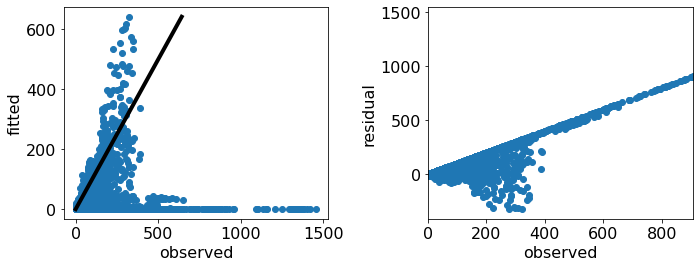

In [26]:
mae, mse, nz_mae, nz_mse, pct_nonzeros = util_eval.eval_mean(test_out_loc, y_test_eval, 'Test', stdout=True)
util_plot.plot_fit_res(y_test_eval.flatten(), test_out_loc.flatten())

## Temporal Distribution of Residuals

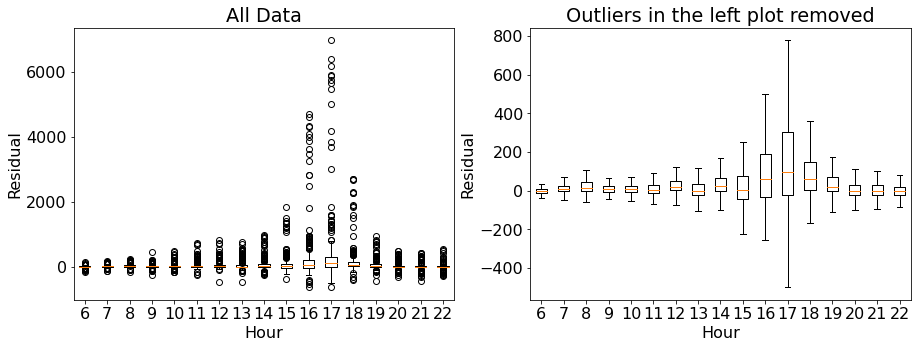

In [85]:
test_res = y_test_eval - test_out_loc
util_plot.plot_res_temp_ind(y_test_eval, test_res, ts_test, n_stations, time_size)

## Temporal Distribution of Residuals (spatially aggregated)

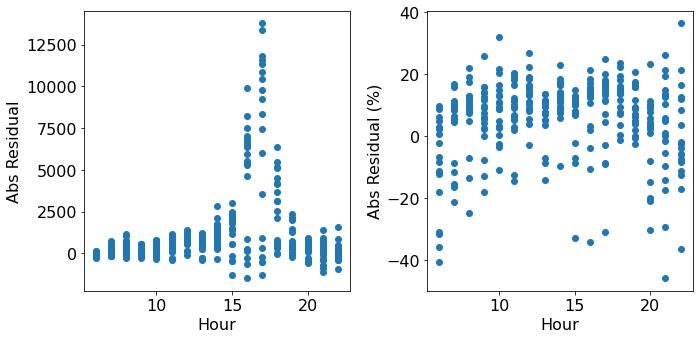

In [87]:
util_plot.plot_res_temp_agg(y_test_eval, test_res, ts_test, time_size, include_zeros=True);

In [ ]:
start_lon = -87.645168, -87.623921, -87.623921, -87.645168
start_lat = 41.872034, 41.872034, 41.889749, 41.889749
end_lon = -87.623921, -87.623921, -87.645168, -87.645168
end_lat = 41.872034, 41.889749, 41.889749, 41.872034
start_points = [Point(xy) for xy in zip(start_lon, start_lat)]
end_points = [Point(xy) for xy in zip(end_lon, end_lat)]
lines = [LineString(xy) for xy in zip(start_points, end_points)]
poly = Polygon(start_points)
poly = gpd.GeoDataFrame([0], crs=CRS("epsg:4326"), geometry=[poly])
chicago = (stations.geometry.x.min(), stations.geometry.y.min(),
           stations.geometry.x.max(), stations.geometry.y.max())
downtown = (-87.645168, 41.872034, -87.623921, 41.889749)
contiguous_usa = gpd.read_file(gplt.datasets.get_path('contiguous_usa'))

pts = gpd.GeoDataFrame(np.array([1,2,3,4]).T, crs=CRS("epsg:4326"), geometry=start_points)
#a = gplt.polyplot(poly, projection=gcrs.WebMercator(), linewidth=4)
a = gplt.pointplot(pts, projection=gcrs.WebMercator())
gplt.webmap(contiguous_usa, projection=gcrs.WebMercator(), ax=a, extent=chicago)
